In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Plot style
sns.set()
%pylab inline
pylab.rcParams['figure.figsize'] = (4, 4)

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%html
<style>
.pquote {
  text-align: left;
  margin: 40px 0 40px auto;
  width: 70%;
  font-size: 1.5em;
  font-style: italic;
  display: block;
  line-height: 1.3em;
  color: #5a75a7;
  font-weight: 600;
  border-left: 5px solid rgba(90, 117, 167, .1);
  padding-left: 6px;
}
.notes {
  font-style: italic;
  display: block;
  margin: 40px 10%;
}
img + em {
  text-align: center;
  display: block;
  color: gray;
  font-size: 0.9em;
  font-weight: 600;
}
</style>

In [4]:
def plotVectors(vecs, cols, alpha=1):
    """
    Plot set of vectors.

    Parameters
    ----------
    vecs : array-like
        Coordinates of the vectors to plot. Each vectors is in an array. For
        instance: [[1, 3], [2, 2]] can be used to plot 2 vectors.
    cols : array-like
        Colors of the vectors. For instance: ['red', 'blue'] will display the
        first vector in red and the second in blue.
    alpha : float
        Opacity of vectors

    Returns:

    fig : instance of matplotlib.figure.Figure
        The figure of the vectors
    """
    plt.axvline(x=0, color='#A9A9A9', zorder=0)
    plt.axhline(y=0, color='#A9A9A9', zorder=0)

    for i in range(len(vecs)):
        if (isinstance(alpha, list)):
            alpha_i = alpha[i]
        else:
            alpha_i = alpha
        x = np.concatenate([[0,0],vecs[i]])
        plt.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                  alpha=alpha_i)

$$
\newcommand\norm[1]{\left\lVert#1\right\rVert} 
\DeclareMathOperator{\Tr}{Tr}
\newcommand\bs[1]{\boldsymbol{#1}}
\newcommand\argmin[1]{\underset{\bs{#1}}{\arg\min}}
\newcommand\argmax[1]{\underset{\bs{#1}}{\arg\max}}
$$

# Introduction

In this final chapter, we'll put together everything we've learning about linear algebra through an application of  Principal Components Analysis.

# 3.12 Principal Components Analysis


**Dimensions** are a crucial topic in data science. The dimensions of a dataset are all of the features (aka variables) of the dataset. For instance, take a look at the [iris dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), a common classification challenge for machine learning models:

<img src="images/iris.jpg">
<em> The famed iris dataset </em>

In this dataset, the rows are the samples (i.e. individual flowers) and the columns are:
 - Sepal Length
 - Sepal Width
 - Petal Length
 - Petal Width
 - Species

Since the object is to predict the species, Sepal Length, Sepal Width, Petal Length and Petal Width are all dimensions. With so few features, it is easy to plot a couple at a time to visualize a potential relationship:

<img src="images/sphx_glr_plot_iris_dataset_002.png" width = 450 height = 450 >
<em> Sepal Length plotted against Sepal Width </em>

But sometimes your dataset has a lot of dimensions - hundreds and maybe even thousands. This can be a problem for reasons that have been summed up as the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). The gist of the curse is that not every sample will possess a value for every dimension when you have hundreds or thousands of dimensions. Such sparsity is problematic for any method that requires statistical significance; it can also obfuscate meaningful patterns that would otherwise be easy to detect. 

The natural solution to the curse of dimensionality is to reduce the number of dimensions in your dataset. But which dimensions should you drop? With hundreds or thousdands of dimensions, it's likely that some of the dimensions will be correlated with one another. When that's the case, they're not really adding anything new information-wise. So the right approach might be dropping dimensions that are highly correlated with others. But the problem here is that you might be losing potentially good information with every dimension you drop, especially when you consider the fact that out-of-sample observtions might be well-explained by these dimensions. Thus your dilemma is to find a way to reduce your dimensionality without losing all of the information present in the dataset as-is.

Enter principal components analysis (PCA). The aim of PCA is to reduce the number of dimensions of a dataset by providing us with a new set of dimensions - called the principal components (PC). These PCs are ordered, with the first PC explaining the largest amount of variance among the original set of dimensions. In addition, each PC is *orthogonal* to the preceding one. Remember that orthogonal vectors possess the property that their dot product is equal to $0$. A handy way to remember/visualize this is to note that the dictionary definition of orthogonal means "of or involving right angles; at right angles." Visually, you can see that these unit vectors are an example of orthogonal vectors:

<img src="images/orthogonal-vectors.png" width="200" alt="Example of orthogonal vectors" title="Orthogonal vectors">
<em>Orthogonal vectors</em>


All this this means is that each PC is [decorrelated](https://en.wikipedia.org/wiki/Decorrelation) to the preceding one. The upshot is that you can choose the number of principal components that you want to reduce your highly dimensional dataset down to (although there are methods that can help you with this choice).

## Describing the problem

The problem can be expressed as finding a function that converts a set of data points from $\mathbb{R}^n$ to $\mathbb{R}^l$. This means that we change the number of dimensions of our dataset. We also need a function that can decode back from the transformed dataset to the initial one:

<img src="images/principal-components-analysis-PCA-change-coordinates.png" width="80%" alt="Principal components analysis (PCA)" title="Principal components analysis (PCA)">
<em>Principal components analysis as a change of coordinate system</em>

The first step is to understand the shape of the data. $x^{(i)}$ is one data point containing $n$ dimensions. Let's have $m$ data points organized as column vectors (one column per point):

$$
\bs{x}=
\begin{bmatrix}
    x^{(1)} & x^{(2)} & \cdots & x^{(m)}
\end{bmatrix}
$$

If we deploy the $n$ dimensions of our data points we will have:

$$
\bs{x}=
\begin{bmatrix}
    x_1^{(1)} & x_1^{(2)} & \cdots & x_1^{(m)}\\\\
    x_2^{(1)} & x_2^{(2)} & \cdots & x_2^{(m)}\\\\
    \cdots & \cdots & \cdots & \cdots\\\\
    x_n^{(1)} & x_n^{(2)} & \cdots & x_n^{(m)}
\end{bmatrix}
$$

We can also write:

$$
\bs{x}=
\begin{bmatrix}
    x_1\\\\
    x_2\\\\
    \cdots\\\\
    x_n
\end{bmatrix}
$$

$c$ will have the shape:

$$
\bs{c}=
\begin{bmatrix}
    c_1\\\\
    c_2\\\\
    \cdots\\\\
    c_l
\end{bmatrix}
$$

## Adding some constraints: the decoding function

The encoding function $f(\bs{x})$ transforms $\bs{x}$ into $\bs{c}$ and the decoding function transforms back $\bs{c}$ into an approximation of $\bs{x}$. To keep things simple, PCA will respect some constraints:

### Constraint 1.

The decoding function has to be a simple matrix multiplication:

$$
g(\bs{c})=\bs{Dc}
$$

By applying the matrix $\bs{D}$ to the dataset from the new coordinates system we should get back to the initial coordinate system.

### Constraint 2.

The columns of $\bs{D}$ must be orthogonal.

### Constraint 3.

The columns of $\bs{D}$ must have unit norm.

## Finding the encoding function

Important: For now we will consider only **one data point**. Thus we will have the following dimensions for these matrices (note that $\bs{x}$ and $\bs{c}$ are column vectors):

<img src="images/principal-components-analysis-PCA-decoding-function.png" width="250" alt="Principal components analysis (PCA) - the decoding function" title="The decoding function">
<em>The decoding function</em>

We want a decoding function which is a simple matrix multiplication. For that reason, we have $g(\bs{c})=\bs{Dc}$. We will then find the encoding function from the decoding function. We want to minimize the error between the decoded data point and the actual data point. With our previous notation, this means reducing the distance between $\bs{x}$ and $g(\bs{c})$. As an indicator of this distance, we will use the squared $L^2$ norm:

$$
\norm{\bs{x} - g(\bs{c})}_2^2
$$

This is what we want to minimize. Let's call $\bs{c}^*$ the optimal $\bs{c}$. Mathematically it can be written:

$$
\bs{c}^* = \underset{c}{\arg\min} \norm{\bs{x} - g(\bs{c})}_2^2
$$

This means that we want to find the values of the vector $\bs{c}$ such that $\norm{\bs{x} - g(\bs{c})}_2^2$ is as small as possible.

If you have a look back to our lesson on vector norms, you'll see that the squared $L^2$ norm can be expressed as:

$$
\norm{\bs{y}}_2^2 = \bs{y}^\text{T}\bs{y}
$$

We have named the variable $\bs{y}$ to avoid confusion with our $\bs{x}$. Here $\bs{y}=\bs{x} - g(\bs{c})$

Thus the equation that we want to minimize becomes:

$$
(\bs{x} - g(\bs{c}))^\text{T}(\bs{x} - g(\bs{c}))
$$

Since the transpose respects addition we have:

$$
(\bs{x}^\text{T} - g(\bs{c})^\text{T})(\bs{x} - g(\bs{c}))
$$

By the distributive property, we can develop:

$$
\bs{x^\text{T}x} - \bs{x}^\text{T}g(\bs{c}) -  g(\bs{c})^\text{T}\bs{x} + g(\bs{c})^\text{T}g(\bs{c})
$$

The commutative property tells us that $
\bs{x^\text{T}y} = \bs{y^\text{T}x}
$. We can use that in the previous equation: $
\bs{x}^\text{T}g(\bs{c}) = g(\bs{c})^\text{T}\bs{x}
$. So the equation becomes:

$$
\bs{x^\text{T}x} -2\bs{x}^\text{T}g(\bs{c}) + g(\bs{c})^\text{T}g(\bs{c})
$$

The first term $\bs{x^\text{T}x}$ does not depends on $\bs{c}$ and since we want to minimize the function according to $\bs{c}$ we can just nix this term. We simplify to:

$$
\bs{c}^* = \underset{c}{\arg\min} -2\bs{x}^\text{T}g(\bs{c}) + g(\bs{c})^\text{T}g(\bs{c})
$$

Since $g(\bs{c})=\bs{Dc}$:

$$
\bs{c}^* = \underset{c}{\arg\min} -2\bs{x}^\text{T}\bs{Dc} + (\bs{Dc})^\text{T}\bs{Dc}
$$

Since $(\bs{Dc})^\text{T}=\bs{c}^\text{T}\bs{D}^\text{T}$, we have:

$$
\bs{c}^* = \underset{c}{\arg\min} -2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{D}^\text{T}\bs{Dc}
$$

As we saw in [2.6](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.6-Special-Kinds-of-Matrices-and-Vectors/), $\bs{D}^\text{T}\bs{D}=\bs{I}_l$ because $\bs{D}$ is orthogonal (actually, it is [semi-orthogonal](https://en.wikipedia.org/wiki/Semi-orthogonal_matrix) if $n \neq l$) and their columns have unit norm. We can replace in the equation:

$$
\bs{c}^* = \underset{c}{\arg\min} -2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{I}_l\bs{c}
$$

$$
\bs{c}^* = \underset{c}{\arg\min} -2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{c}
$$

### Minimizing the function

Now the goal is to find the minimum of the function $- 2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{c}$. One widely used way of doing that is to use the **gradient descent** algorithm. It is not the focus of this chapter but we will say a word about it.

The main idea is that the sign of the [derivative](https://en.wikipedia.org/wiki/Derivative) of the function at a specific value of $x$ tells you if you need to increase or decrease $x$ to reach the minimum. When the slope is near $0$, the minimum should have been reached.

<img src="images/gradient-descent.png" width="400" alt="Mechanism of the gradient descent algorithm" title="Mechanism of the gradient descent algorithm">
<em>Gradient descent</em>

However, functions with local minima can trouble the descent:

<img src="images/gradient-descent-local-minima.png" width="400" alt="Gradient descent in the case of local minimum" title="Gradient descent">
<em>Gradient descent can get stuck in local minima</em>

These examples are in 2 dimensions but the principle stands for higher dimensional functions as well. In higher dimensions, the gradient is a vector containing the [partial derivatives](https://en.wikipedia.org/wiki/Partial_derivative) of all dimensions. Its mathematical notation is $\nabla_xf(\bs{x})$.

### Calculating the gradient of the function

Here we want to minimize through each dimension of $\bs{c}$. We are looking for a slope of $0$. The equation is:

$$
\nabla_c(-2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{c})=0
$$

Let's take these terms separately to calculate the derivative according to $\bs{c}$. 

$$
\frac{d(-2\bs{x}^\text{T}\bs{Dc})}{d\bs{c}} = -2\bs{x}^\text{T}\bs{D}
$$

The second term is $\bs{c}^\text{T}\bs{c}$. We can develop the vector $\bs{c}$ and calculate the derivative for each element:

$$
\begin{align*}
\frac{d(\bs{c}\text{T}\bs{c})}{d\bs{c}} &=
\left(\frac{d(\bs{c}_1^2 + \bs{c}_2^2 + \cdots + \bs{c}_l^2)}{d\bs{c}_1},
\frac{d(\bs{c}_1^2 + \bs{c}_2^2 + \cdots + \bs{c}_l^2)}{d\bs{c}_2},
\cdots,
\frac{d(\bs{c}_1^2 + \bs{c}_2^2 + \cdots + \bs{c}_l^2)}{d\bs{c}_l}\right) \\\\
&=(2\bs{c}_1, 2\bs{c}_2, \cdots, 2\bs{c}_l)\\\\
&=2(\bs{c}_1, \bs{c}_2, \cdots, \bs{c}_l)\\\\
&=2\bs{c}
\end{align*}
$$

So we can plug in our derivatives:

$$
\nabla_c(-2\bs{x}^\text{T}\bs{Dc} + \bs{c}^\text{T}\bs{c})=0\\\\
-2\bs{x}^\text{T}\bs{D} + 2\bs{c}=0\\\\
-2\bs{D}^\text{T}\bs{x} + 2\bs{c}=0\\\\
\bs{c}=\bs{D}^\text{T}\bs{x}
$$

Great! We found the encoding function! Here are its dimensions:

<img src="images/principal-components-analysis-PCA-encoding-function.png" width="250" alt="Expression of the encoding function" title="The encoding function">
<em>The encoding function</em>

To go back from $\bs{c}$ to $\bs{x}$ we use $g(\bs{c})=\bs{Dc}$:

$$
r(\bs{x}) = g(f(\bs{x})=\bs{D}\bs{D}^\text{T}\bs{x}
$$

<img src="images/principal-components-analysis-PCA-reconstruction-function.png" width="300" alt="Expression of the reconstruction function" title="The reconstruction function">
<em>The reconstruction function</em>

## Finding $\bs{D}$

The next step is to find the matrix $\bs{D}$. Recall that the purpose of the PCA is to change the coordinate system in order to maximize the variance along the first dimensions of the projected space. This is equivalent to minimizing the error between data points and their reconstruction ([cf here](https://stats.stackexchange.com/questions/32174/pca-objective-function-what-is-the-connection-between-maximizing-variance-and-m)).

### The Frobenius norm

Since we have to take all points into account (the same matrix $\bs{D}$ will be used for all points) we will use the Frobenius norm of the errors, which is equivalent to the $L^2$ norm for matrices. Here's the formula for the Frobenius norm:

$$
\norm{\bs{A}}_F=\sqrt{\sum_{i,j}A^2_{i,j}}
$$

It is like if you unroll the matrix to end up with a one dimensional vector and that you take the $L^2$ norm of this vector.

We will call $\bs{D}^*$ the optimal $\bs{D}$ (in the sense that the error is as small as possible). We have:

$$
\bs{D}^* = \underset{\bs{D}}{\arg\min} \sqrt{\sum_{i,j}(x_j^{(i)}-r(\bs{x}^{(i)})_j})^2
$$

With the constraint that $\bs{D}^\text{T}\bs{D}=\bs{I}_l$ because we have chosen the constraint of having the columns of $\bs{D}$ orthogonal.

### The first principal component

We will start to find only the first principal component (PC). For that reason, we will have $l=1$. So the matrix $\bs{D}$ will have the shape $(n \times 1)$: it is a simple column vector. Since it is a vector we will call it $\bs{d}$:

<img src="images/first-principal-component.png" width="100" alt="Dimension of the first principal component" title="The first principal component">
<em>The first principal component</em>

We can therefore remove the sum over $j$ and the square root since we will take the squared $L^2$ norm:

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \sum_{i}\norm{(\bs{x}^{(i)}-r(\bs{x}^{(i)}))}_2^2
$$


We have also seen that:

$$
r(\bs{x})=\bs{D}\bs{D}^\text{T}\bs{x}
$$

Since we are looking only for the first PC:

$$
r(\bs{x})=\bs{d}\bs{d}^\text{T}\bs{x}
$$

We can plug $r(\bs{x})$ into the equation:

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \sum_{i}\norm{\bs{x}^{(i)}-\bs{dd}^\text{T}\bs{x}^{(i)}}_2^2
$$

Because of constraint 3 (the columns of $\bs{D}$ must have unit norms), we have $\norm{\bs{d}}_2 = 1$. $\bs{d}$ is one of the columns of $\bs{D}$ and thus has a unit norm.


Instead of using the sum along the $m$ data points $\bs{x}$ we can have the matrix $\bs{X}$ gather all of the observations:

$$
\bs{X} = \begin{bmatrix}
    \bs{x}^{(1)\text{T}}\\\\
    \bs{x}^{(2)\text{T}}\\\\
    \cdots\\\\
    \bs{x}^{(m)\text{T}}
\end{bmatrix}=
\begin{bmatrix}
    \bs{x}_1^{(1)} & \bs{x}_2^{(1)} & \cdots & \bs{x}_n^{(1)}\\\\
    \bs{x}_1^{(2)} & \bs{x}_2^{(2)} & \cdots & \bs{x}_n^{(2)}\\\\
    \cdots & \cdots & \cdots & \cdots\\\\
    \bs{x}_0^{(m)} & \bs{x}_1^{(m)} & \cdots & \bs{x}_n^{(m)}
\end{bmatrix}
$$

We want $\bs{x}^{(i)\text{T}}$ instead of $\bs{x}^{(i)}$ in our expression of $\bs{d}^*$. We can transpose the content of the norm:

$$
\begin{align*}
\bs{d}^* &= \underset{\bs{d}}{\arg\min} \sum_{i}\norm{(\bs{x}^{(i)}-\bs{dd}^\text{T}\bs{x}^{(i)})^\text{T}}_2^2\\\\
&=\underset{\bs{d}}{\arg\min} \sum_{i}\norm{\bs{x}^{(i)\text{T}}-\bs{x}^{(i)\text{T}}\bs{dd}^\text{T}}_2^2\\\\
\end{align*}
$$

and

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \norm{\bs{X}-\bs{X}\bs{dd}^\text{T}}_\text{F}^2
$$

with the constraint that $\bs{dd}^\text{T}=1$.

### Using the Trace operator

We will now use the Trace operator to simplify the equation. Recall that:

$$
\norm{\bs{A}}_F=\sqrt{\Tr({\bs{AA}^T})}
$$

So here $\bs{A}=\bs{X}-\bs{X}\bs{dd}^\text{T}$. So we have:

$$
\bs{d}^* = \underset{\bs{d}}{\arg\min} \Tr{((\bs{X}-\bs{Xdd}^\text{T})}(\bs{X}-\bs{Xdd}^\text{T})^\text{T})
$$

Since the trace is invariant under [cyclic permutations](https://en.wikipedia.org/wiki/Cyclic_permutation), we can write:

$$
\begin{align*}
\bs{d}^* &= \argmin{d} \Tr{((\bs{X}-\bs{Xdd}^\text{T})^\text{T}}(\bs{X}-\bs{Xdd}^\text{T}))\\\\
&=\argmin{d} \Tr{((\bs{X}^\text{T}-(\bs{Xdd}^\text{T})^\text{T})}(\bs{X}-\bs{Xdd}^\text{T}))
\end{align*}
$$

And $(\bs{Xdd}^\text{T})^\text{T}=(\bs{d}^\text{T})^\text{T}\bs{d}^\text{T}\bs{X}^\text{T}=\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}$. Let's plug that into our equation:


$$
\begin{align*}
\bs{d}^* &= \argmin{d} \Tr{(\bs{X}^\text{T}-\bs{d}\bs{d}^\text{T}\bs{X}^\text{T})}(\bs{X}-\bs{Xdd}^\text{T}))\\\\
&= \argmin{d} \Tr{(\bs{X}^\text{T}\bs{X}-\bs{X}^\text{T}\bs{Xdd}^\text{T} -\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{X} +\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xdd}^\text{T}})\\\\
&= \argmin{d} \Tr{(\bs{X}^\text{T}\bs{X})} - \Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}
- \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{X})} + \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xdd}^\text{T})}
\end{align*}
$$

We can remove the first term that does not depend on $d$:

$$
\bs{d}^* = \argmin{d} - \Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}
- \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{X})} + \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xdd}^\text{T})}
$$

And because of the cycling property of a trace, we have:

$$
\Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})} = \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{X})}
$$

We can simplify to:

$$
\bs{d}^* = \argmin{d} -2\Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}
 + \Tr{(\bs{d}\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xdd}^\text{T})}
$$

and then

$$
\bs{d}^* = \argmin{d} -2\Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}
 + \Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T}\bs{d}\bs{d}^\text{T})}
$$

Because of the constraint $\bs{dd}^\text{T}=1$:

$$
\begin{align*}
\bs{d}^* &= \argmin{d} -2\Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}
 + \Tr{(\bs{X}^\text{T}\bs{Xd}\bs{d}^\text{T})}\textrm{ subject to }\bs{dd}^\text{T}=1\\\\
&= \argmin{d} -\Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}\textrm{ subject to }\bs{dd}^\text{T}=1\\\\
&=\argmax{d} \Tr{(\bs{X}^\text{T}\bs{Xdd}^\text{T})}\textrm{ subject to }\bs{dd}^\text{T}=1
\end{align*}
$$

and with the cycling property:

$$
\bs{d}^* = \argmax{d} \Tr{(\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xd})} \textrm{ subject to }\bs{dd}^\text{T}=1
$$

### Eigendecomposition

We will see that we can find the maximum of the function by calculating the eigenvectors of $\bs{X^\text{T}X}$.


### Covariance matrix

As we wrote above, the optimization problem of maximizing the variance of the components and minimizing the error between the reconstructed and the actual data are equivalent. Actually, if you look at the formula of $\bs{d}$ you can see that there is the term $\bs{X^\text{T}X}$ in the middle.

If we have centered our data around 0 (see bellow for more details about centering), $\bs{X^\text{T}X}$ is the covariance matrix (see [this Quora question](https://www.quora.com/Why-do-we-need-to-center-the-data-for-Principle-Components-Analysis)).

The covariance matrix is a $n$ by $n$ matrix ($n$ being the number of dimensions). Its diagonal is the variance of the corresponding dimensions and the other cells are the covariance between the two corresponding dimensions (the amount of redundancy).

<img src="images/covariance_matrix.png" >

The larger the covariance we have between two dimensions, the more redundancy exists between these dimensions. This also means that the best-fit line is associated with small errors if the covariance is high. To maximize the variance and minimize the covariance (in order to decorrelate the dimensions) means that the ideal covariance matrix is a diagonal matrix (non-zero values in the diagonal only). Therefore the diagonalization of the covariance matrix will give us the optimal solution.

### Example 2.

As an example we will create a 2D data set. To see the effect of the PCA we will introduce some correlations between the two dimensions. Let's create 100 data points with 2 dimensions:

In [5]:
np.random.seed(123)
x = 5*np.random.rand(100)
y = 2*x + 1 + np.random.randn(100)

x = x.reshape(100, 1)
y = y.reshape(100, 1)

X = np.hstack([x, y])
X.shape

(100, 2)

Let's plot the data:

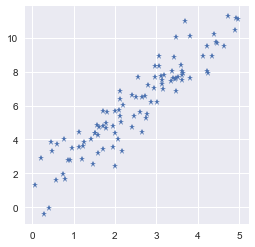

In [6]:
plt.plot(X[:,0], X[:,1], '*')
plt.show()

Highly correlated data means that the dimensions are redundant. It is possible to predict one from the other without losing much information.

The first processing we will do is to center the data around 0. PCA is a regression model without intercept (see [here](https://stats.stackexchange.com/questions/22329/how-does-centering-the-data-get-rid-of-the-intercept-in-regression-and-pca)) and the first component must therefore cross the origin.

Here is a simple function that substracts the mean of each column from each data point within the column. It can be used to center the data points around 0.

In [7]:
def centerData(X):
    X = X.copy()
    X -= np.mean(X, axis = 0)
    return X

So let's center our data $\bs{X}$ around 0 for both dimensions:

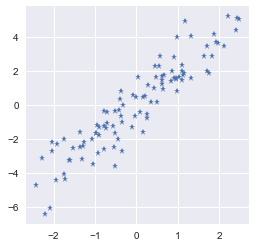

In [8]:
X_centered = centerData(X)
plt.plot(X_centered[:,0], X_centered[:,1], '*')
plt.show()

As you can see, the middle of our y-axis is now $0$.

We can now look for PCs. We saw that they correspond to values taken by $\bs{d}$ that maximize the following function:

$$
\bs{d}^* = \argmax{d} \Tr{(\bs{d}^\text{T}\bs{X}^\text{T}\bs{Xd})} \textrm{ subject to }\bs{dd}^\text{T}=1
$$

To find $\bs{d}$ we can calculate the eigenvectors of $\bs{X^\text{T}X}$. So let's do that:

In [9]:
eigVals, eigVecs = np.linalg.eig(X_centered.T.dot(X_centered)/100)
eigVecs

array([[-0.91116273, -0.41204669],
       [ 0.41204669, -0.91116273]])

In [10]:
print(np.linalg.eig(X_centered.T.dot(X_centered)))
print(np.linalg.eig(X_centered.T.dot(X_centered)/100))

(array([ 18.04730409, 798.35242844]), array([[-0.91116273, -0.41204669],
       [ 0.41204669, -0.91116273]]))
(array([0.18047304, 7.98352428]), array([[-0.91116273, -0.41204669],
       [ 0.41204669, -0.91116273]]))


These are the vectors maximizing our function. Each column vector is associated with an eigenvalue. The vector associated with the larger eigenvalue tells us the direction associated with the larger variance in our data. To check that, we will plot these vectors along with the data. 

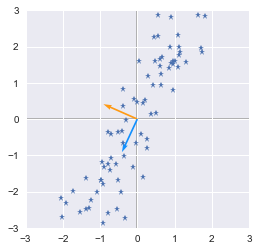

In [11]:
orange = '#FF9A13'
blue = '#1190FF'
plotVectors(eigVecs.T, [orange, blue])
plt.plot(X_centered[:,0], X_centered[:,1], '*')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

We can see that the blue vector direction corresponds to the oblique shape of our data. The idea is that if you project the data points on the line corresponding to the blue vector, you'll maximize the explained variance. Have a look at the following figure:

<img src="images/principal-component-analysis-variance-explained.png" width="400" alt="Representation of the variance explained across directions" title="Maximizing the variance">
<em>Projection of the data point: this line direction is the one with the largest variance</em>

When you project data points on the pink line there is more variance. This line has the direction that maximizes the variance of the data points. It is the same for the figure above: our blue vector has the direction of the line where data point projection has the higher variance. Then the second eigenvector is orthogonal to the first.

In our figure above, the blue vector is the second eigenvector so let's check that it is the one associated with the bigger eigenvalue:

In [12]:
eigVals

array([0.18047304, 7.98352428])

So yes, the second vector corresponds to the biggest eigenvalue.

Now that we have found the matrix $\bs{d}$ we will use the encoding function to rotate the data. The goal of the rotation is to end up with a new coordinate system where data is uncorrelated and thus where the basis axes gather all the variance. It is then possible to keep only few a axes: this is the purpose of dimensionality reduction.

Recall that the encoding function is:

$$
\bs{c}=\bs{D}^\text{T}\bs{x}
$$

$\bs{D}$ is the matrix containing the eigenvectors that we have calculated before. In addition, this formula corresponds to only one data point where dimensions are the rows of $\bs{x}$. In our case, we will apply it to all data points and since $\bs{X}$ has dimensions on the columns we need to transpose it.

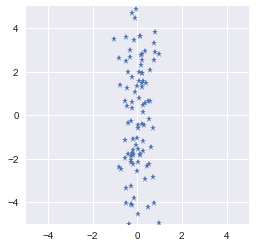

In [13]:
X_new = eigVecs.T.dot(X_centered.T)

plt.plot(eigVecs.T.dot(X_centered.T)[0, :], eigVecs.T.dot(X_centered.T)[1, :], '*')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

It worked! The rotation transformed our dataset so that we now have the more variance on one of the basis axes. You could keep only this dimension and have a fairly good representation of the data.

### About the unit norm constraint

We saw that the maximization is subject to $\bs{dd}^\text{T}=1$. This means that the solution vector has to be a unit vector. Without this constraint, you could scale $\bs{d}$ up to infinity to increase the function to maximize (see [here](https://stats.stackexchange.com/questions/117695/why-is-the-eigenvector-in-pca-taken-to-be-unit-norm)). For instance, let's see some vectors $\bs{x}$ that could maximize the function:

In [14]:
d = np.array([[12], [26]])
d.T.dot(X.T).dot(X).dot(d)

array([[4165298.04389264]])

However this $\bs{d}$ does not have a unit norm (since $\bs{d}$ is a column vector we use the transpose of $\bs{dd}^\text{T}$:

In [15]:
d.T.dot(d)

array([[820]])

The eigenvectors have unit norm and thus respect the constraint:

In [16]:
eigVecs[:,0].dot(eigVecs[:,0].T)

1.0000000000000002

and

In [17]:
eigVecs[:,1].dot(eigVecs[:,1].T)

1.0000000000000002

# References

## PCA

- Visualize PCA:  http://setosa.io/ev/principal-component-analysis/

- A lot of intuitive explanations on PCA: https://arxiv.org/pdf/1404.1100.pdf

- https://brilliant.org/wiki/principal-component-analysis/#from-approximate-equality-to-minimizing-function

- http://www4.ncsu.edu/~slrace/LinearAlgebra2017/Slides/PCAPrint.pdf

- https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

- https://www.cs.bgu.ac.il/~inabd171/wiki.files/lecture14_handouts.pdf

## Semi-orthogonal matrix

- https://en.wikipedia.org/wiki/Semi-orthogonal_matrix

## Intuition about PCA

- https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/

## Derivatives

- https://math.stackexchange.com/questions/1377764/derivative-of-vector-and-vector-transpose-product

## Link between variance maximized and error minimized:

- https://stats.stackexchange.com/questions/130721/what-norm-of-the-reconstruction-error-is-minimized-by-the-low-rank-approximation

- https://stats.stackexchange.com/questions/32174/pca-objective-function-what-is-the-connection-between-maximizing-variance-and-m

- https://stats.stackexchange.com/questions/318625/why-do-the-leading-eigenvectors-of-a-maximize-texttrdtad

## Centering data

- https://www.quora.com/Why-do-we-need-to-center-the-data-for-Principle-Components-Analysis
- https://stats.stackexchange.com/questions/22329/how-does-centering-the-data-get-rid-of-the-intercept-in-regression-and-pca

## Unit norm constraint

- https://stats.stackexchange.com/questions/117695/why-is-the-eigenvector-in-pca-taken-to-be-unit-norm